In [1]:
import pydriller
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from IPython import display
import pandas as pd

**Task 1: Author analysis**

In [2]:
elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"

In [3]:
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [4]:
# with this code we can check if some files have been renamed/removed

#for c in repo.traverse_commits():
#    for mf in c.modified_files:
#        if mf.old_path and (mf.new_path != mf.old_path):
#            print(mf.old_path, "->", mf.new_path)
            
# we have two cases:
# old_name --> new_name (renamed) : here we consider the new path (we could also consider the old_path)
# old_name --> None (removed) : here we consider the old_path
#
# we have also:
# old_name == new_name (modified file) : here we consider the new path
# None --> new_name (created) : here we consider the new path

In [5]:
# we create the dictionary author => number of modified files

authors_nmodif_dictionary = {}

for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1 
        else:
            if mf.old_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1  
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), key=lambda item: item[1], reverse=True)}

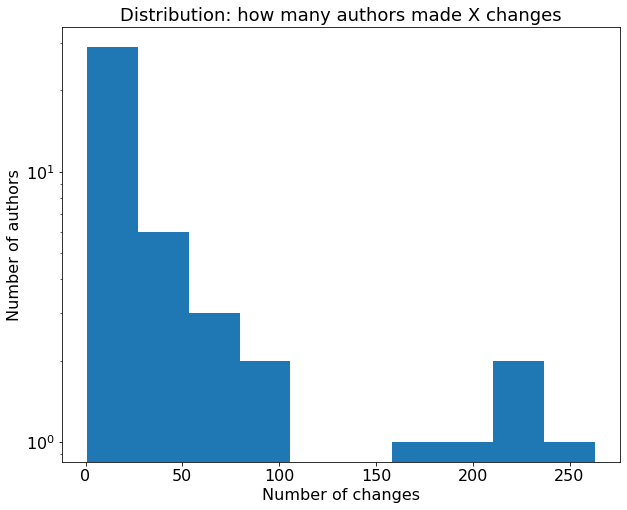

In [25]:
# visualization: number of authors (y) who modified n files (x)

plt.figure(figsize=(10,8))
plt.title("Distribution: how many authors made X changes", fontsize=18)
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of changes", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.show()

We can see a clear tendency for the distribution: the more changes, the less number of authors. In other words, there are a lot of authors who made between 0 - 25 changes, but only a few who did more than 100. Actually, there only 5 developers with more than 150 changes. These could indicate us who are the people who have a better understanding of the system. However, we would need to consider how big are these changes to have a complete picture of the contributions, since we do not know how the different contributors work, and it could happen that a person with few but big changes contributed more than another with a lot but small changes.

In [27]:
# we create the dictionary file => number of authors

file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
        else:
            if mf.old_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

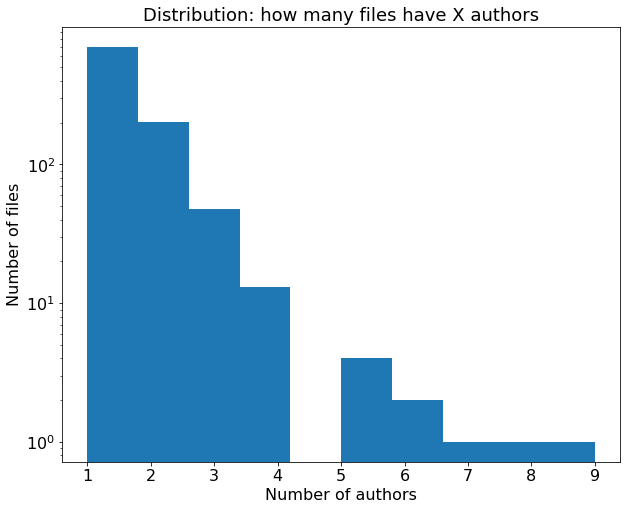

In [28]:
# visualization: number files (y) with n authors (x)

plt.figure(figsize=(10,8))
plt.title("Distribution: how many files have X authors", fontsize=18)
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.xlabel("Number of authors", fontsize=16)
plt.ylabel("Number of files", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.show()

The plotted distribution indicates that there are a lot of files which have a small number of authors while there are a few that have a large number. In fact, most of the files of the repository for the analyzed timeframe have a single author. This could indicate that developers tend to work on the same files so a file is modified for the one who knows it the better, or that the files have been not modified since they were created. We would need to complement this result with other data to know what is the case, and spot possible ownership problems.

In [31]:
from enum import Enum

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [32]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # if the file has been removed, we checked if it was removed from the corresponding path
            if not mf.new_path:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # if the file has been added, we checked if it was added the to corresponding path
            elif not mf.old_path:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # otherwise, we checked if the file is/was in the corresponding path
            else:
                if mf.new_path.startswith(filepath) or mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)

                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [33]:
# we get the contributions for the three indicated packages

filepath = "src\\main\\java\\org\\elasticsearch\\search"
author_contributions_search = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\index"
author_contributions_index = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\action"
author_contributions_action = get_modification_loc(Modification.TOTAL, filepath)

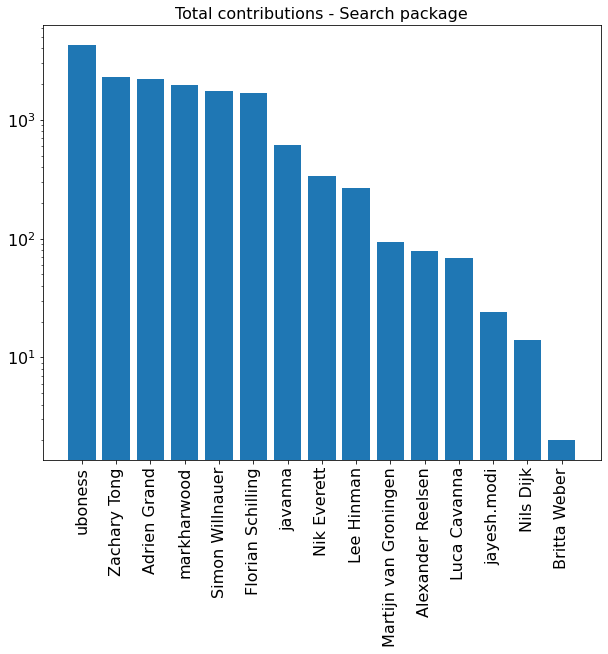

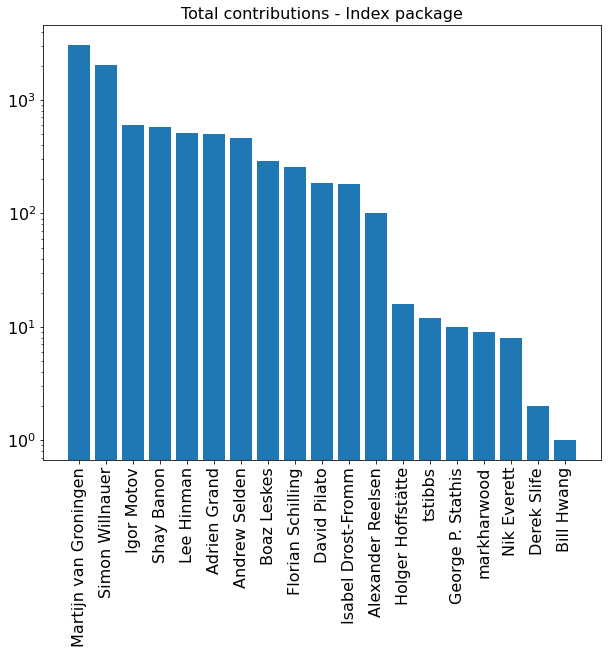

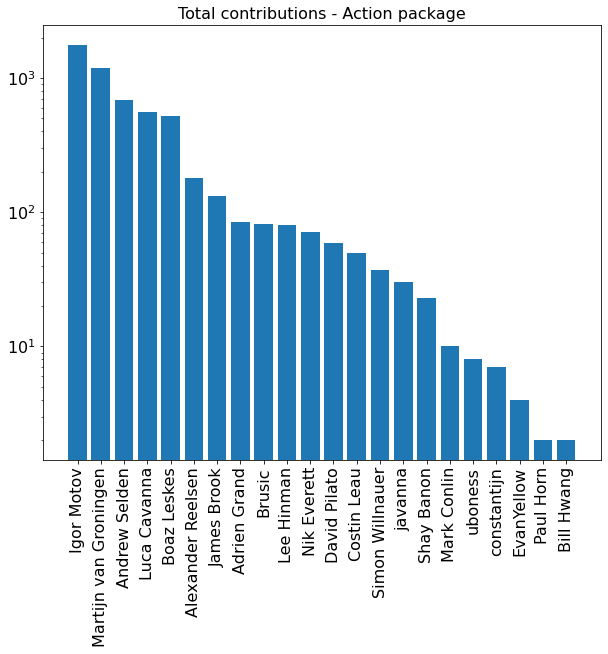

In [66]:
def plot_author_contributions(author_contributions, title):
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=16)
    plt.bar(author_contributions.keys(), author_contributions.values())
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    
plot_author_contributions(author_contributions_search, 'Total contributions - Search package')
plot_author_contributions(author_contributions_index, 'Total contributions - Index package')
plot_author_contributions(author_contributions_action, 'Total contributions - Action package')

The three packages show a similar tendency: there is a contributor which has done most of the contributions. This indicates that there is a person who has most of the knowledge for these packages. We can calculate the pertentage of the contributions for the main authors by dividing their contributions by the total for the package. By doing this, we can see that the main authors did around the 30% of the modifications. The biggest gap with the rest of the developers happens for the index package, where the main contributor did almost the 35% of the changes.

**Task 2: Knowledge loss**

In [50]:
def colorFader(c1,c2,mix=0):
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

def generate_knowledge_loss_json(author_contributions, package_name):

    total_contribution = sum(list(author_contributions.values()))

    output_json = {}
    output_json["name"] = "root"

    children_node_d = {}
    children_node_d["name"] = package_name
    children_node_d["children"] = []
    
    n = len(author_contributions)
    colors = []
    c1='red'
    c2='black'
    for x in range(n):
        colors.append(colorFader(c1,c2,x/n))
    
    children_list = []
    color_index = 0
    for contributor, contribution in author_contributions.items():
        temp = {}
        temp["author_color"] = colors[color_index]
        color_index += 1
        temp["size"] = str(contribution)
        temp["name"] = contributor
        temp["weight"] = contribution
        temp["ownership"] = contribution/total_contribution
        temp["children"] = []
        children_list.append(temp)

    children_node_d["children"] = children_list

    children_node = []
    children_node.append(children_node_d)

    output_json["children"] = children_node

    with open(f"{package_name}.json", "w") as file:
        json.dump(output_json, file, indent=4)

In [51]:
# this generates the json needed for the knowledge loss map
generate_knowledge_loss_json(author_contributions_index, "index_package")

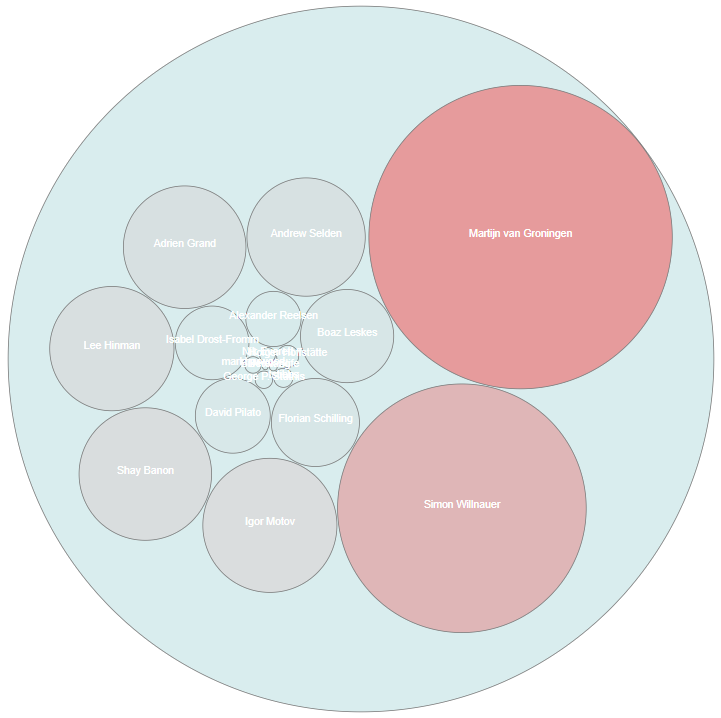

In [52]:
display.Image("knowledge_loss_map_index_package.png")

As indicated before, we found that the worst package in terms of knowledge loss is the index package. This is even clearer after plotting the knowledge loss map: we can see how Martijn van Groningen predominates over all other authors.

By looking at the numerical proportions, the main author has the following predominance over the other authors :
- The main author has almost the 35% of the total contributions.
- The main contributor did 1.5 more contributions than the second author with more contributions to the package.
- The main contributor did 5.11 more contributions than the third author with more contributions to the package.

Definitively, Martijn van Groningen could be consider the main contributor of the package, and it may be worthy to consider how to reduce the dependency with him.

**Task 3: Code Churn Analysis**

In [56]:
churn_dictionary = {}

# generate date range and initialize dictionary
dates = []
for c in repo.traverse_commits():
    dates.append(c.author_date.strftime("%Y/%m/%d"))
date_range = pd.date_range(start=min(dates), end=max(dates))
for date in date_range:
    churn_dictionary[date.strftime("%y/%m/%d")] = 0
    
# get modified lines for each commit and populate dictionary    
for c in repo.traverse_commits():
    date = c.author_date.strftime("%y/%m/%d")
    count = 0
    for mf in c.modified_files:
        count += mf.added_lines + mf.deleted_lines
    churn_dictionary[date] += count

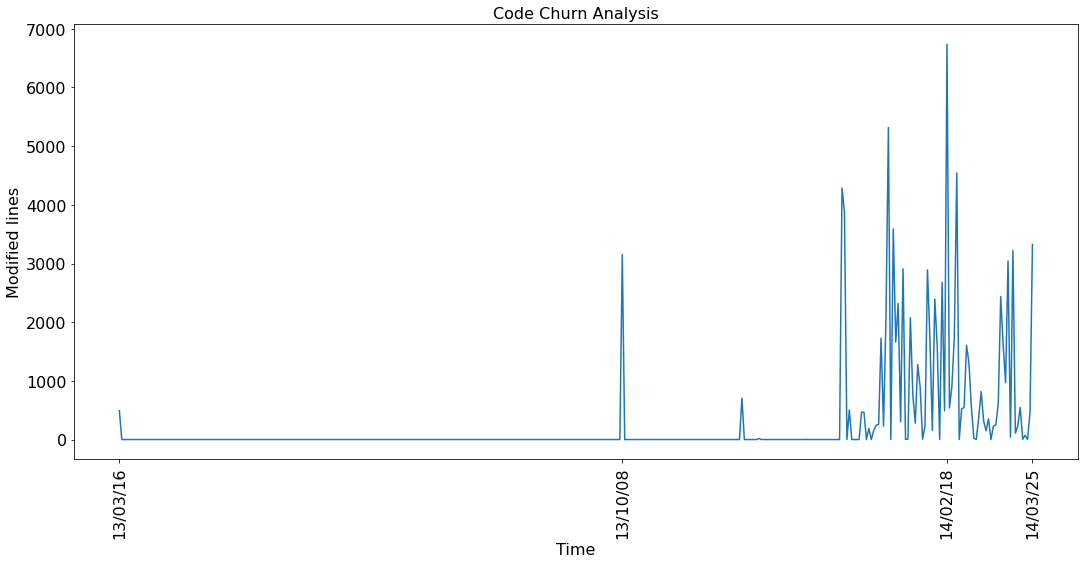

In [69]:
plt.figure(figsize=(18,8))
plt.ylabel("Modified lines", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.tick_params(axis='both', labelsize=16)
plt.title("Code Churn Analysis", fontsize=16)
plt.plot(churn_dictionary.keys(), churn_dictionary.values())
plt.xticks([list(churn_dictionary.keys())[0], '13/10/08', '14/02/18', 
            list(churn_dictionary.keys())[-1]], visible=True, rotation="vertical")
plt.show()

We have picked the following dates to analyze the outliers (indicated on the plot):
- 08/10/2013
- 18/02/2014

The associated hashes are:
- 08/10/2013 (single commit)

    8c592101aee9640b42bd9336db33ad7f09d339d2
    
    
- 18/02/2014 (multiple commit)

    0bce68e38e66a35ea82d1a331be5263e82451dd1
    
    776ace22734429edc1a9cc2379cf2626b7f81e07
    
    9538e7ddf0e0f7e67e72675b449ffbfe1ed63251
    
    14c4beb7197786cd2d3ba4d8abbc341f73dbb2e6
    
    a40f504b97222768bd0c462b9234bcdbfe723fa0
    
    77f37a9123cfde448bb9a4c19472182c844589cf
    
    91627fa57acad8a0f93a4a240c6162e58b832444